# <font color='green'>Combining bit-flip and phase-flip repetition codes: Shor's 9-qubit code</font>

So far, we have seen how to encode qubits to protect from bit-flip and phase-flip errors, but only one of these two kinds of errors at a time. The Shor code, discovered by Peter Shor in 1995, was the first quantum error-correcting code that could protect against both bit-flip and phase-flip errors. It achieves this through a clever technique called **concatenation** -- essentially nesting one code inside another.

### <font color='red'>Encoding procedure</font>

The Shor code uses 9 physical qubits to encode 1 logical qubit:
1. First, it encodes against phase-flip errors (like the 3-qubit phase-flip code)
2. Then, it encodes each of those 3 qubits against bit-flip errors (using the 3-qubit bit-flip code)

This gives us 3 × 3 = 9 physical qubits total which will serve as the data qubits. Here, we build the Shor code from scratch, and simulate the logical error probability of the Shor code for various physical error probabilities. In the process, we will also use 8 additional ancillary qubits, for a total of 17 physical qubits.

In [1]:
import numpy as np, random
import matplotlib.pyplot as plotter
import cirq
from math import floor, comb
from myMWPM import MWPMDecoder1D
import time

In [2]:
def create_shor_encoder(block_size = 3):

    qubits = cirq.LineQubit.range(block_size * block_size)
    circuit = cirq.Circuit()
    # outer phase encoding
    for i in range(1, block_size):
        circuit.append([
            cirq.CNOT(qubits[0], qubits[block_size * i]),
    ])

    circuit.append(cirq.Moment(
                cirq.H.on_each(*[qubits[i*block_size] for i in range(block_size)])
        )
    )
    
    # inner bit-flip encoding
    for i in range(block_size):
        block_start = i * block_size
        for j in range(1, block_size):
            circuit.append([
                cirq.CNOT(qubits[block_start], qubits[block_start + j]),
            ])
    return circuit

In [3]:
encoder = create_shor_encoder(block_size = 3)
print(encoder)

0: ───@───@───H───@───@───
      │   │       │   │
1: ───┼───┼───────X───┼───
      │   │           │
2: ───┼───┼───────────X───
      │   │
3: ───X───┼───H───@───@───
          │       │   │
4: ───────┼───────X───┼───
          │           │
5: ───────┼───────────X───
          │
6: ───────X───H───@───@───
                  │   │
7: ───────────────X───┼───
                      │
8: ───────────────────X───


In [4]:
def get_shor_bitflip_syndrome_measurement(block_size = 3):
    
    circuit = cirq.Circuit()
    data_qubits = cirq.LineQubit.range(block_size * block_size)
    bitflip_ancilla_start_index = len(data_qubits)
    bitflip_ancilla_qubits = cirq.LineQubit.range(bitflip_ancilla_start_index, bitflip_ancilla_start_index + (block_size - 1)*block_size)
    
    for block_index in range(block_size):
        for within_block_index in range(block_size-1):
            data_qubit_index = block_index * block_size + within_block_index
            ancilla_index = block_index * (block_size-1) + within_block_index
            circuit.append([
                cirq.CNOT(data_qubits[data_qubit_index], bitflip_ancilla_qubits[ancilla_index]),
                cirq.CNOT(data_qubits[data_qubit_index + 1], bitflip_ancilla_qubits[ancilla_index]),
            ])
            # circuit.append(cirq.Moment(cirq.I.on_each(*data_qubits)))

    circuit.append(cirq.measure(*bitflip_ancilla_qubits, key = 'bitflip-syndrome'))

    return circuit

In [5]:
bitflip_syndrome_meas = get_shor_bitflip_syndrome_measurement(block_size = 3)
print(bitflip_syndrome_meas)

       ┌───┐   ┌───┐   ┌───┐   ┌───┐
0: ─────@──────────────────────────────────────────────────────
        │
1: ─────┼───────@───────@──────────────────────────────────────
        │       │       │
2: ─────┼───────┼───────┼───────@──────────────────────────────
        │       │       │       │
3: ─────┼@──────┼───────┼───────┼──────────────────────────────
        ││      │       │       │
4: ─────┼┼──────┼@──────┼@──────┼──────────────────────────────
        ││      ││      ││      │
5: ─────┼┼──────┼┼──────┼┼──────┼@─────────────────────────────
        ││      ││      ││      ││
6: ─────┼┼@─────┼┼──────┼┼──────┼┼─────────────────────────────
        │││     ││      ││      ││
7: ─────┼┼┼─────┼┼@─────┼┼@─────┼┼─────────────────────────────
        │││     │││     │││     ││
8: ─────┼┼┼─────┼┼┼─────┼┼┼─────┼┼@────────────────────────────
        │││     │││     │││     │││
9: ─────X┼┼─────X┼┼─────┼┼┼─────┼┼┼────M('bitflip-syndrome')───
         ││      ││     │││     │││    │
10:

In [6]:
def get_shor_phaseflip_syndrome_measurement(block_size = 3):
    
    circuit = cirq.Circuit()
    data_qubits = cirq.LineQubit.range(block_size * block_size)
    bitflip_ancilla_start_index = len(data_qubits)
    bitflip_ancilla_qubits = cirq.LineQubit.range(bitflip_ancilla_start_index, bitflip_ancilla_start_index + (block_size - 1) * block_size)
    phaseflip_ancilla_start_index = len(data_qubits) + len(bitflip_ancilla_qubits)
    phaseflip_ancilla_qubits = cirq.LineQubit.range(phaseflip_ancilla_start_index, phaseflip_ancilla_start_index + (block_size - 1))

    circuit.append(cirq.Moment(cirq.H.on_each(*data_qubits)))
    # block 0 flips all phaseflip ancillas
    for data_qubit_index in range(block_size):
        for phaseflip_ancilla_index in range(block_size - 1):
            circuit.append(
                cirq.CNOT(data_qubits[data_qubit_index], phaseflip_ancilla_qubits[phaseflip_ancilla_index])
            )
            # circuit.append(cirq.Moment(cirq.I.on_each(*phaseflip_ancilla_qubits)))


    for block_index in range(1, block_size):
        data_qubit_start_index = block_size * block_index
        for data_qubit_index in range(data_qubit_start_index, data_qubit_start_index + block_size):
            circuit.append(
                cirq.CNOT(data_qubits[data_qubit_index], phaseflip_ancilla_qubits[block_index - 1])
            )
            # circuit.append(cirq.Moment(cirq.I.on_each(*phaseflip_ancilla_qubits)))

    circuit.append(cirq.Moment(cirq.H.on_each(*data_qubits)))
    circuit.append(cirq.measure(*phaseflip_ancilla_qubits, key = 'phaseflip-syndrome'))
   
    return circuit

In [7]:
phaseflip_syndrome_meas = get_shor_phaseflip_syndrome_measurement(block_size = 3)
print(phaseflip_syndrome_meas)

               ┌──┐   ┌──┐   ┌──┐   ┌──┐   ┌──┐
0: ────H───@────@─────────────────────────────────────H─────────────────────────
           │    │
1: ────H───┼────┼@─────@──────────────────────────────H─────────────────────────
           │    ││     │
2: ────H───┼────┼┼─────┼@─────@───────────────────────H─────────────────────────
           │    ││     ││     │
3: ────H───┼────┼┼─────┼┼─────┼@──────────────────────H─────────────────────────
           │    ││     ││     ││
4: ────H───┼────┼┼─────┼┼─────┼┼─────@────────────────H─────────────────────────
           │    ││     ││     ││     │
5: ────H───┼────┼┼─────┼┼─────┼┼─────┼──────@─────────H─────────────────────────
           │    ││     ││     ││     │      │
6: ────H───┼────┼┼─────┼┼─────┼┼─────┼@─────┼─────────H─────────────────────────
           │    ││     ││     ││     ││     │
7: ────H───┼────┼┼─────┼┼─────┼┼─────┼┼─────┼@────────H─────────────────────────
           │    ││     ││     ││     ││     ││
8: ────H───┼────┼┼

In [8]:
def create_initial_state(starting_state = '+'):
    
    starting_circuit = cirq.Circuit()
    starting_qubit = cirq.LineQubit(0)

    if starting_state == '0':
        starting_circuit.append(cirq.Moment(cirq.I(starting_qubit)))
    elif starting_state == '1':
        starting_circuit.append(cirq.Moment(cirq.X(starting_qubit)))
    elif starting_state == '+':
        starting_circuit.append(cirq.Moment(cirq.H(starting_qubit)))
    elif starting_state == '-':
        starting_circuit.append(cirq.Moment(cirq.H(starting_qubit)))
        starting_circuit.append(cirq.Moment(cirq.Z(starting_qubit)))

    return starting_circuit

In [9]:
create_initial_state('+')

0: ───H───

In [10]:
def create_noise_circuit(p = 0.1, block_size = 3):

    def flip(p):
        return 1 if random.random() < p else 0
    
    noise_circuit = cirq.Circuit()
    data_qubits = cirq.LineQubit.range(block_size * block_size)

    has_error = [flip(p) for _ in range(len(data_qubits))]
    error_indices = [i for i, x in enumerate(has_error) if x == 1]
    errors = []
    for error_index in error_indices:
        random_error = np.random.choice([cirq.Z])
        noise_circuit.append(random_error(data_qubits[error_index]))
        errors.append(random_error)

    return noise_circuit, [error_indices, errors]

In [11]:
def get_shor_code_logical_error_probability(p = 0.1, block_size = 3, n_shots = 1000, simulator = cirq.CliffordSimulator(), starting_state = '+'):
    print(starting_state)
    starting_circuit = create_initial_state(starting_state = starting_state)
    encoder_circuit = create_shor_encoder(block_size = block_size)
    bitflip_syndrome_circuit = get_shor_bitflip_syndrome_measurement(block_size = block_size)
    phaseflip_syndrome_circuit = get_shor_phaseflip_syndrome_measurement(block_size = block_size)
    
    decoder = MWPMDecoder1D(num_qubits=block_size)

    num_logical_errors = 0
    for i in range(n_shots):
        full_shor_circuit = cirq.Circuit()
        noise_circuit, noise_applied = create_noise_circuit(p = p, block_size = block_size)
        #print(noise_applied)
        full_shor_circuit = starting_circuit + encoder_circuit + noise_circuit + bitflip_syndrome_circuit + phaseflip_syndrome_circuit
    
        result = simulator.run(full_shor_circuit, repetitions = 1)
        bitflip_syndromes = result.measurements['bitflip-syndrome'][0]
        phaseflip_syndromes = result.measurements['phaseflip-syndrome'][0]
    
        decoded_bitflip_errors = []
        # decoding bit flips
        for i in range(0, len(bitflip_syndromes), block_size-1):  # Slice list in steps of block_size
            these_syndromes = bitflip_syndromes[i:i+block_size-1]
            withinblock_error_indices = decoder.decode(these_syndromes)
            error_locations = [int(i // (block_size-1))*block_size + x for x in withinblock_error_indices]
            for error_loc in error_locations:
                decoded_bitflip_errors.append([error_loc, cirq.X])
    
        # decoding phase flips
        block_errors_0 = [0]
        block_errors_1 = [1]
        for j in range(len(phaseflip_syndromes)):
            # assume block 0 has no phase flip errors
            block_errors_0.append(0 ^ phaseflip_syndromes[j])
            block_errors_1.append(1 ^ phaseflip_syndromes[j])
        # pick the option with minimum weight
        if sum(block_errors_0) <= sum(block_errors_1):
            block_errors_final = block_errors_0
        else:
            block_errors_final = block_errors_1
    
        decoded_phaseflip_error_blocks = [i for i, thisblock_error in enumerate(block_errors_final) if thisblock_error == 1]
    
        # decide whether or not a logical error occurred
        # since the bit flip blocks are encoded as 000+111, any number of bit flip errors within each block
        # can be undone by finding the odd ones using a pairwise parity check, and reversing the error
        # back into 000+111. there is information in the syndrome measurements to help us do this.
        # the phase-flip is trickier. if the blocks where phase flips happened are detected, and the specific qubits identified, 
        # then a single Z in the block can undo the flip and we're all good. but if the phase flip is not identified
        # for example because two phase-flips happened within a block, then a logical error happens
    
        is_logical_error = False
        qubits_with_errors, qubit_errors = noise_applied

        
        # bitflip_error_logical_blocks = []
        # for qubit_with_error, qubit_error in zip(qubits_with_errors, qubit_errors):
            # if qubit_error == cirq.X:
                # if [qubit_with_error, cirq.X] not in decoded_bitflip_errors:
                    # thisqubit_block = qubit_with_error // block_size
                    # bitflip_error_logical_blocks.append(thisqubit_block)
        # bitflip_error_logical_blocks = list(set(bitflip_error_logical_blocks))
        
        for qubit_with_error, qubit_error in zip(qubits_with_errors, qubit_errors):
            if qubit_error == cirq.Z:
                thisqubit_block = qubit_with_error // block_size
                if thisqubit_block not in decoded_phaseflip_error_blocks:
                    is_logical_error = True
    
        if is_logical_error:
            num_logical_errors += 1
    return num_logical_errors * 1./ n_shots

In [12]:
get_shor_code_logical_error_probability(p = 0.01, block_size = 3, n_shots = 10000, starting_state = '+')

+


0.0037

In [13]:
get_shor_code_logical_error_probability(p = 0.01, block_size = 3, n_shots = 10000, starting_state = '-')

-


0.0037

In [14]:
get_shor_code_logical_error_probability(p = 0.01, block_size = 3, n_shots = 10000, starting_state = '0')

0


0.0032

In [15]:
get_shor_code_logical_error_probability(p = 0.01, block_size = 3, n_shots = 10000, starting_state = '1')

1


0.0035

In [16]:
def get_logical_error_probability_simulated(block_sizes, physical_errors, n_shots, simulator = cirq.CliffordSimulator(), starting_state = '+'):
    
    all_logical_errors = []
    for block_size in block_sizes:
        print(f"Simulating block-size-{block_size} Shor code circuits")
        thisblock_size_logicalerrors = []
        for physical_error in physical_errors:
            print(f"Physical error probability = {physical_error}")
            t = time.time()
            logical_error = get_shor_code_logical_error_probability(
                                p = physical_error,
                                block_size = block_size,
                                n_shots = n_shots,
                                simulator = simulator,
                                starting_state = starting_state
                            )
            elapsed = time.time() - t
            print(f"Took {elapsed:.0f} seconds")

            thisblock_size_logicalerrors.append(logical_error)
            print(f"p = {physical_error}, p_L = {logical_error}")
        all_logical_errors.append(thisblock_size_logicalerrors)

    return all_logical_errors

In [17]:
starting_state = '+'
block_sizes = [3]
physical_errors = np.logspace(-3, 0, 10)  # 10^-3 = 0.001 to 10^0 = 1 in 10 steps
# physical_errors = np.array([0.01])
simulator = cirq.CliffordSimulator()
all_logical_errors = get_logical_error_probability_simulated(block_sizes, physical_errors, 
                                                             n_shots = 50000, simulator = simulator,
                                                             starting_state = starting_state)

Simulating block-size-3 Shor code circuits
Physical error probability = 0.001
+
Took 86 seconds
p = 0.001, p_L = 6e-05
Physical error probability = 0.0021544346900318843
+
Took 85 seconds
p = 0.0021544346900318843, p_L = 0.00024
Physical error probability = 0.004641588833612777
+
Took 86 seconds
p = 0.004641588833612777, p_L = 0.00082
Physical error probability = 0.01
+
Took 87 seconds
p = 0.01, p_L = 0.0033
Physical error probability = 0.021544346900318832
+
Took 87 seconds
p = 0.021544346900318832, p_L = 0.01464
Physical error probability = 0.046415888336127774
+
Took 87 seconds
p = 0.046415888336127774, p_L = 0.06196
Physical error probability = 0.1
+
Took 88 seconds
p = 0.1, p_L = 0.22682
Physical error probability = 0.21544346900318823
+
Took 89 seconds
p = 0.21544346900318823, p_L = 0.60002
Physical error probability = 0.46415888336127775
+
Took 92 seconds
p = 0.46415888336127775, p_L = 0.96056
Physical error probability = 1.0
+
Took 96 seconds
p = 1.0, p_L = 1.0


In [18]:
def get_logical_error_probability_analytical(block_sizes, physical_errors):
    all_analytical_errors = []
    for block_size in block_sizes:
        analytical_success = 0
        for i in range(floor(block_size/2.)+1):
            analytical_success += comb(block_size**2, i) * physical_errors**i * (1-physical_errors)**(block_size**2-i)
        analytical_errors = 1-analytical_success
        all_analytical_errors.append(analytical_errors)

    return all_analytical_errors

In [19]:
all_analytical_errors = get_logical_error_probability_analytical(block_sizes, physical_errors)

In [20]:
def plot_logical_error_probabilities(block_sizes, physical_errors, all_logical_errors, all_analytical_errors):
    
    plotter.figure(figsize=(10, 8))
    colors = plotter.cm.viridis(np.linspace(0, 0.8, len(block_sizes)))
    
    plotter.loglog(physical_errors, physical_errors, label = 'Unprotected qubit',
                      linewidth=2, linestyle = '--', color='gray',
                      )
    for block_size, logical_errors, analytical_errors, color in zip(block_sizes, all_logical_errors, all_analytical_errors, colors):
        plotter.loglog(physical_errors, logical_errors, label = f'Shor code (block-size = {block_size}) simulated',
                      marker='o', linewidth=2, markersize=8,
                      color=color,
                      )
        plotter.loglog(physical_errors, analytical_errors, label = f'Shor code(block-size = {block_size}) analytical',
                      linewidth=2, linestyle = '--', color=color,
                      )
    
    plotter.legend()
    plotter.xlim([physical_errors.min(), physical_errors.max()])
    plotter.xlabel('Physical error probability')
    plotter.ylabel('Logical error probability')
    plotter.tight_layout()
    plotter.show()

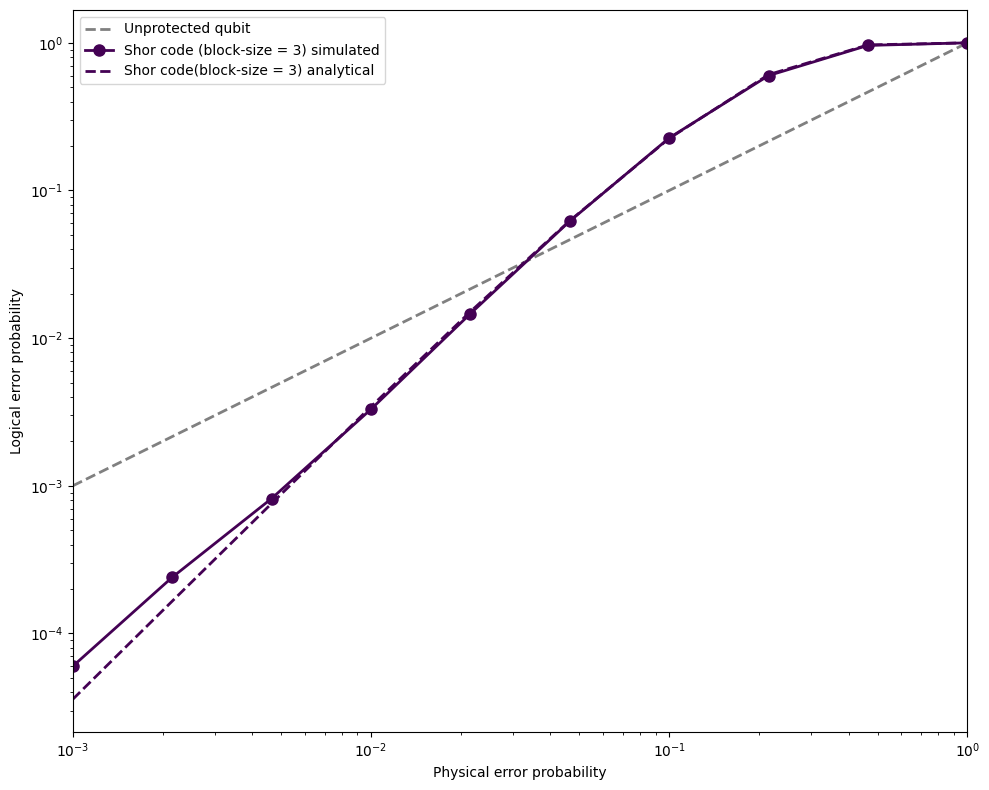

In [21]:
plot_logical_error_probabilities(
    block_sizes,
    physical_errors,
    all_logical_errors,
    all_analytical_errors
)